In [ ]:
!pip install numpy
!pip install matplotlib
!pip install pandas

In [1]:
from bitarray import bitarray
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random
import pandas as pd
import json
import time, datetime
import os
import glob

In [56]:
def get_values(data) :
    #print(data)
    #print(data['reaction_cycle'])
    res = data['results']   
    input_size = data['input_file_size']
    bytes_per_oligo = data['bytes_per_oligo']
    reaction_cycle = data['reaction_cycle']
    number_of_simulations = data['number_of_simulations']

    # print(len(res['error_bytes_in_correct_address_data']))

    address_errors_with_catfish = []
    for i,v in enumerate(list(res['address_error_catfish_count'])) :
        address_errors_with_catfish.append(v + list(res['address_error_count'])[i])

    #print(address_errors_with_catfish)
    error_bytes = []
    #print(list(res['error_bytes_in_correct_address_data']))
    for i,v in enumerate(list(res['error_bytes_in_correct_address_data'])) :
        error_bytes.append(v + (address_errors_with_catfish[i] * bytes_per_oligo))
        if (v + (address_errors_with_catfish[i] * bytes_per_oligo)) > 1024:
            print(str(address_errors_with_catfish[i]) + ' : ' + str(v))
    
    oligo_count = np.ceil(data['input_file_size'] / data['bytes_per_oligo'])
    oligo_count_sum = oligo_count * number_of_simulations

    # lost_byte_sum = (np.sum(address_errors_with_catfish) * bytes_per_oligo) + sum(res['error_bytes_in_correct_address_data'])
    lost_byte_sum = np.sum(error_bytes)
    lost_byte_avg = np.average(error_bytes)
    lost_byte_max = np.max(error_bytes)
    lost_byte_min = np.min(error_bytes)
    total_bytes = reaction_cycle * input_size * number_of_simulations
    lost_byte_total_per = (lost_byte_sum / total_bytes) * 100
    lost_byte_avg_per = (lost_byte_avg / input_size) * 100
    lost_byte_max_per = (lost_byte_max / input_size) * 100
    lost_byte_min_per = (lost_byte_min / input_size) * 100


    address_error_sum = np.sum(address_errors_with_catfish)
    address_error_avg = np.average(address_errors_with_catfish)
    address_error_max = np.max(address_errors_with_catfish)
    address_error_min = np.min(address_errors_with_catfish)
    address_error_sum_per = (address_error_sum / oligo_count_sum) * 100
    address_error_avg_per = (address_error_avg / oligo_count) * 100
    address_error_max_per = (address_error_max / oligo_count) * 100
    address_error_min_per = (address_error_min / oligo_count) *100


    # print(str(lost_byte_sum) + '/' + str(total_bytes))
    # print(str(lost_byte_avg) + '/' + str(input_size))
    # print(lost_byte_max)
    # print(lost_byte_min)
    # print(str(address_error_sum) + '/' + str(np.ceil(data['input_file_size'] / data['bytes_per_oligo']) * data['number_of_simulations'])[:-2])
    r = {'lost_byte_sum':lost_byte_sum,
        'lost_byte_avg':lost_byte_avg,
        'lost_byte_max':lost_byte_max,
        'lost_byte_min':lost_byte_min,
        'lost_byte_total_per':lost_byte_total_per,
        'lost_byte_avg_per':lost_byte_avg_per,
        'lost_byte_max_per':lost_byte_max_per,
        'lost_byte_min_per':lost_byte_min_per,
        'address_error_sum':address_error_sum,
        'address_error_avg':address_error_avg,
        'address_error_max':address_error_max,
        'address_error_min':address_error_min,
        'address_error_sum_per':address_error_sum_per,
        'address_error_avg_per':address_error_avg_per,
        'address_error_max_per':address_error_max_per,
        'address_error_min_per':address_error_min_per
        }
    
    return r

In [140]:
dump_file_directory = './dump_datas/*'
dump_files = glob.glob(dump_file_directory)
parsed_dump_files = []
for v in dump_files :
    with open(v) as f :
        parsed_dump_files.append(json.load(f))

# 欠損

      lost_byte_sum  lost_byte_avg  lost_byte_max  lost_byte_min  \
20.0        1023980       1023.980           1024           1022   
5.0         1013466       1013.466           1024            978   
0.0               0          0.000              0              0   
0.1          108258        108.258            248             16   
10.0        1023177       1023.177           1024           1014   
2.0          902645        902.645            989            789   
0.2          207201        207.201            363             78   
1.0          682347        682.347            861            451   
0.5          438199        438.199            644            272   

      lost_byte_total_per  lost_byte_avg_per  lost_byte_max_per  \
20.0            99.998047          99.998047         100.000000   
5.0             98.971289          98.971289         100.000000   
0.0              0.000000           0.000000           0.000000   
0.1             10.572070          10.572070       

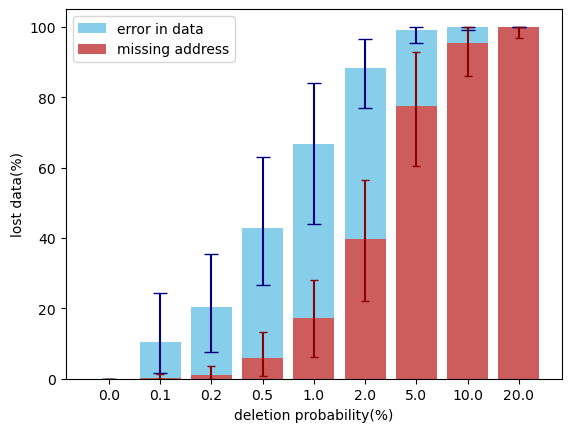

In [126]:
data = filter(lambda x : x['over_extension_numerator'] == 0 and x['miss_extension_numerator'] == 0 and x['reaction_cycle'] == 1 ,parsed_dump_files)
#file_size = list(data)[0]['input_file_size']
vs = []
index = []
for d in data:
    vs.append(get_values(d))
    #index.append(str(d['deletion_numerator']) + '-' + str(d['over_extension_numerator']) + '-' + str(d['miss_extension_numerator']) + '-' + str(d['reaction_cycle']))
    index.append((d['deletion_numerator'] / 1000)*100)
#v = get_values(list(fed)[0])
df = pd.DataFrame(vs,index=index)
print(df)
df.sort_index(inplace=True)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel="deletion probability(%)", ylabel="lost data(%)")
ax.bar(range(len(df)),
 df['lost_byte_avg_per'],
 yerr=[df['lost_byte_avg_per'] - df['lost_byte_min_per'],
 df['lost_byte_max_per'] - df['lost_byte_avg_per']],
 tick_label=df.index,
 capsize=5,
 color='skyblue',
 ecolor='navy')

ax.bar(range(len(df)), 
(df['lost_byte_avg_per'] * df['address_error_avg_per'])/100,
tick_label=df.index,
capsize=3,
yerr=[(((df['lost_byte_avg_per'] * df['address_error_avg_per'])/100) - ((df['lost_byte_avg_per'] * df['address_error_min_per'])/100)),
     (((df['lost_byte_avg_per'] * df['address_error_max_per'])/100) - ((df['lost_byte_avg_per'] * df['address_error_avg_per'])/100))],
color="indianred",
ecolor="darkred")

ax.legend(('error in data','lost address'))


# 欠損と反応サイクル数

   lost_byte_sum  lost_byte_avg  lost_byte_max  lost_byte_min  \
1        1023980       1023.980           1024           1022   
5          35709         35.709            105              0   
3         599705        599.705            767            400   
4         169263        169.263            305             42   
6           7084          7.084             55              0   
2        1002073       1002.073           1024            941   

   lost_byte_total_per  lost_byte_avg_per  lost_byte_max_per  \
1            99.998047          99.998047         100.000000   
5             0.697441           3.487207          10.253906   
3            19.521647          58.564941          74.902344   
4             4.132397          16.529590          29.785156   
6             0.115299           0.691797           5.371094   
2            48.929346          97.858691         100.000000   

   lost_byte_min_per  address_error_sum  address_error_avg  address_error_max  \
1          99.

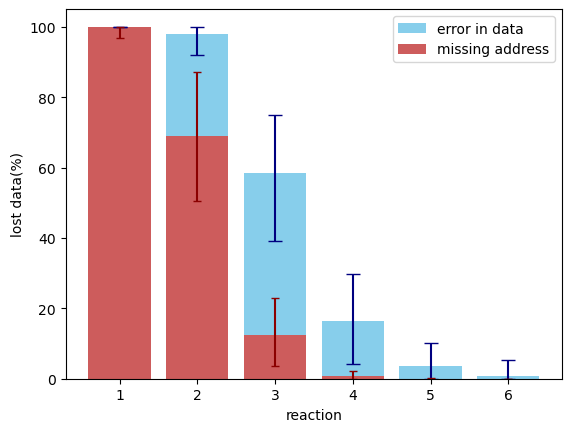

In [127]:
data = filter(lambda x : x['deletion_numerator'] == 200 ,parsed_dump_files)
#file_size = list(data)[0]['input_file_size']
vs = []
index = []
for d in data:
    vs.append(get_values(d))
    #index.append(str(d['deletion_numerator']) + '-' + str(d['over_extension_numerator']) + '-' + str(d['miss_extension_numerator']) + '-' + str(d['reaction_cycle']))
    index.append(d['reaction_cycle'])
#v = get_values(list(fed)[0])
df = pd.DataFrame(vs,index=index)
print(df)
df.sort_index(inplace=True)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel="reaction", ylabel="lost data(%)")
ax.bar(range(len(df)),
 df['lost_byte_avg_per'],
 yerr=[df['lost_byte_avg_per'] - df['lost_byte_min_per'],
 df['lost_byte_max_per'] - df['lost_byte_avg_per']],
 tick_label=df.index,
 capsize=5,
 color='skyblue',
 ecolor='navy')

ax.bar(range(len(df)), 
(df['lost_byte_avg_per'] * df['address_error_avg_per'])/100,
tick_label=df.index,
capsize=3,
yerr=[(((df['lost_byte_avg_per'] * df['address_error_avg_per'])/100) - ((df['lost_byte_avg_per'] * df['address_error_min_per'])/100)),
     (((df['lost_byte_avg_per'] * df['address_error_max_per'])/100) - ((df['lost_byte_avg_per'] * df['address_error_avg_per'])/100))],
color="indianred",
ecolor="darkred")

ax.legend(('error in data','lost address'))


# 塩基エラー

       lost_byte_sum  lost_byte_avg  lost_byte_max  lost_byte_min  \
0.20          162112        162.112            339             48   
0.10           85145         85.145            250              5   
0.00               0          0.000              0              0   
5.00         1005302       1005.302           1024            952   
20.00        1023999       1023.999           1024           1023   
10.00        1023339       1023.339           1024           1010   
0.02           17416         17.416             89              0   
0.50          355020        355.020            525            184   
1.00          587186        587.186            787            382   
2.00          832440        832.440            944            687   
0.01            8773          8.773             55              0   
0.05           42480         42.480            142              0   

       lost_byte_total_per  lost_byte_avg_per  lost_byte_max_per  \
0.20             15.831250        

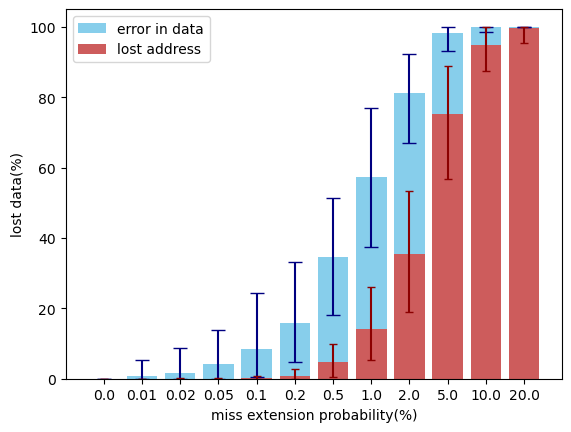

In [131]:
data = filter(lambda x : x['over_extension_numerator'] == 0 and x['deletion_numerator'] == 0 and x['reaction_cycle'] == 1 ,parsed_dump_files)
#file_size = list(data)[0]['input_file_size']
vs = []
index = []
for d in data:
    vs.append(get_values(d))
    #index.append(str(d['deletion_numerator']) + '-' + str(d['over_extension_numerator']) + '-' + str(d['miss_extension_numerator']) + '-' + str(d['reaction_cycle']))
    index.append((d['miss_extension_numerator'] / 10000)*100)
#v = get_values(list(fed)[0])
df = pd.DataFrame(vs,index=index)
print(df)
df.sort_index(inplace=True)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel="miss extension probability(%)", ylabel="lost data(%)")
ax.bar(range(len(df)),
 df['lost_byte_avg_per'],
 yerr=[df['lost_byte_avg_per'] - df['lost_byte_min_per'],
 df['lost_byte_max_per'] - df['lost_byte_avg_per']],
 tick_label=df.index,
 capsize=5,
 color='skyblue',
 ecolor='navy')

ax.bar(range(len(df)), 
(df['lost_byte_avg_per'] * df['address_error_avg_per'])/100,
tick_label=df.index,
capsize=3,
yerr=[(((df['lost_byte_avg_per'] * df['address_error_avg_per'])/100) - ((df['lost_byte_avg_per'] * df['address_error_min_per'])/100)),
     (((df['lost_byte_avg_per'] * df['address_error_max_per'])/100) - ((df['lost_byte_avg_per'] * df['address_error_avg_per'])/100))],
color="indianred",
ecolor="darkred")

ax.legend(('error in data','lost address'))


# 塩基エラーと反応数

   lost_byte_sum  lost_byte_avg  lost_byte_max  lost_byte_min  \
3        1023993       1023.993           1024           1021   
4        1024000       1024.000           1024           1024   
1        1005302       1005.302           1024            952   
5        1024000       1024.000           1024           1024   
6        1024000       1024.000           1024           1024   
2        1022677       1022.677           1024           1005   

   lost_byte_total_per  lost_byte_avg_per  lost_byte_max_per  \
3            33.333105          99.999316              100.0   
4            25.000000         100.000000              100.0   
1            98.174023          98.174023              100.0   
5            20.000000         100.000000              100.0   
6            16.666667         100.000000              100.0   
2            49.935400          99.870801              100.0   

   lost_byte_min_per  address_error_sum  address_error_avg  address_error_max  \
3          99.

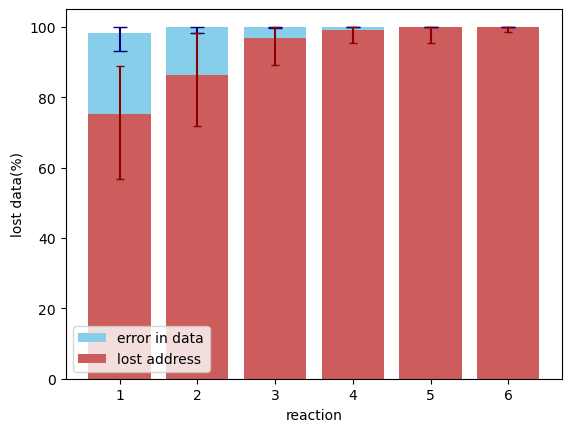

In [141]:
data = filter(lambda x : x['miss_extension_numerator'] == 500 ,parsed_dump_files)
#file_size = list(data)[0]['input_file_size']
vs = []
index = []
for d in data:
    vs.append(get_values(d))
    #index.append(str(d['deletion_numerator']) + '-' + str(d['over_extension_numerator']) + '-' + str(d['miss_extension_numerator']) + '-' + str(d['reaction_cycle']))
    index.append(d['reaction_cycle'])
#v = get_values(list(fed)[0])
df = pd.DataFrame(vs,index=index)
print(df)
df.sort_index(inplace=True)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel="reaction", ylabel="lost data(%)")
ax.bar(range(len(df)),
 df['lost_byte_avg_per'],
 yerr=[df['lost_byte_avg_per'] - df['lost_byte_min_per'],
 df['lost_byte_max_per'] - df['lost_byte_avg_per']],
 tick_label=df.index,
 capsize=5,
 color='skyblue',
 ecolor='navy')

ax.bar(range(len(df)), 
(df['lost_byte_avg_per'] * df['address_error_avg_per'])/100,
tick_label=df.index,
capsize=3,
yerr=[(((df['lost_byte_avg_per'] * df['address_error_avg_per'])/100) - ((df['lost_byte_avg_per'] * df['address_error_min_per'])/100)),
     (((df['lost_byte_avg_per'] * df['address_error_max_per'])/100) - ((df['lost_byte_avg_per'] * df['address_error_avg_per'])/100))],
color="indianred",
ecolor="darkred")

ax.legend(('error in data','lost address'))


# 過剰伸長

      lost_byte_sum  lost_byte_avg  lost_byte_max  lost_byte_min  \
2.0               0            0.0              0              0   
0.2               0            0.0              0              0   
0.0               0            0.0              0              0   
20.0              0            0.0              0              0   
10.0              0            0.0              0              0   
0.5               0            0.0              0              0   
5.0               0            0.0              0              0   
0.1               0            0.0              0              0   
1.0               0            0.0              0              0   

      lost_byte_total_per  lost_byte_avg_per  lost_byte_max_per  \
2.0                   0.0                0.0                0.0   
0.2                   0.0                0.0                0.0   
0.0                   0.0                0.0                0.0   
20.0                  0.0                0.0       

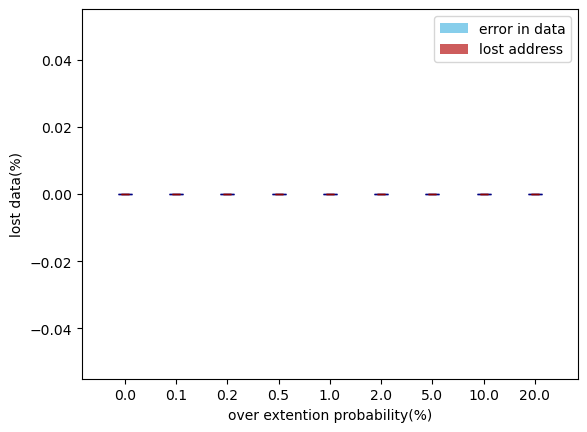

In [130]:
data = filter(lambda x : x['deletion_numerator'] == 0 and x['miss_extension_numerator'] == 0 and x['reaction_cycle'] == 1 ,parsed_dump_files)
#file_size = list(data)[0]['input_file_size']
vs = []
index = []
for d in data:
    vs.append(get_values(d))
    #index.append(str(d['deletion_numerator']) + '-' + str(d['over_extension_numerator']) + '-' + str(d['miss_extension_numerator']) + '-' + str(d['reaction_cycle']))
    index.append((d['over_extension_numerator'] / 1000)*100)
#v = get_values(list(fed)[0])
df = pd.DataFrame(vs,index=index)
print(df)
df.sort_index(inplace=True)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel="over extention probability(%)", ylabel="lost data(%)")
ax.bar(range(len(df)),
 df['lost_byte_avg_per'],
 yerr=[df['lost_byte_avg_per'] - df['lost_byte_min_per'],
 df['lost_byte_max_per'] - df['lost_byte_avg_per']],
 tick_label=df.index,
 capsize=5,
 color='skyblue',
 ecolor='navy')

ax.bar(range(len(df)), 
(df['lost_byte_avg_per'] * df['address_error_avg_per'])/100,
tick_label=df.index,
capsize=3,
yerr=[(((df['lost_byte_avg_per'] * df['address_error_avg_per'])/100) - ((df['lost_byte_avg_per'] * df['address_error_min_per'])/100)),
     (((df['lost_byte_avg_per'] * df['address_error_max_per'])/100) - ((df['lost_byte_avg_per'] * df['address_error_avg_per'])/100))],
color="indianred",
ecolor="darkred")

ax.legend(('error in data','lost address'))


In [64]:
dump_file_directory = './dump_datas/*'
dump_files = glob.glob(dump_file_directory)
parsed_dump_files = []
for v in dump_files :
    with open(v) as f :
        parsed_dump_files.append(json.load(f))

# print(parsed_dump_files)

df = pd.DataFrame(parsed_dump_files)
#fed = filter(lambda x : x['deletion_numerator'] == 5 and x['reaction_cycle'] == 1 ,parsed_dump_files)
fed = filter(lambda x : x['deletion_numerator'] == 200 ,parsed_dump_files)

vs = []
index = []
for d in fed:
    vs.append(get_values(d))
    #index.append(str(d['deletion_numerator']) + '-' + str(d['over_extension_numerator']) + '-' + str(d['miss_extension_numerator']) + '-' + str(d['reaction_cycle']))
    index.append(d['reaction_cycle'])
#v = get_values(list(fed)[0])
df = pd.DataFrame(vs,index=index)
print(df)

#print(list(fed)[0]['results']['address_error_count'])
# print(df)
#q = df.query('deletion_numerator == 1')
# print(q)
# print(get_values(q['results']))

            lost_byte_sum  lost_byte_avg  lost_byte_max  lost_byte_min  \
0-20-0-1                0          0.000              0              0   
0-2-0-1                 0          0.000              0              0   
200-0-0-1         1023980       1023.980           1024           1022   
0-0-20-1           162112        162.112            339             48   
0-200-0-3               0          0.000              0              0   
50-0-0-1          1013466       1013.466           1024            978   
0-0-10-1            85145         85.145            250              5   
0-0-0-1                 0          0.000              0              0   
0-200-0-1               0          0.000              0              0   
0-100-0-1               0          0.000              0              0   
0-0-1-4             38815         38.815            113              0   
200-0-0-5           35709         35.709            105              0   
0-0-500-1         1005302       1005.3